Using Resnet50 Pretrained Model in Keras

Problem 1 - Code Review

In [25]:
import numpy as np
import pandas as pd
from random import randint

import matplotlib.pyplot as plt
plt.style.use('classic')  # Valid style
import gc

import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split
from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from tqdm import tqdm  # Corrected to use 'tqdm' instead of 'tqdm_notebook'
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
# from tensorflow.keras.utils import conv_utils
# from tensorflow.keras.utils.data_utils import get_file
# from tensorflow.keras.engine.topology import get_source_inputs
from tensorflow.keras import InputSpec
from tensorflow.keras import backend as K
# from tensorflow.keras.applications.imagenet_utils import
import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import SpatialDropout2D  # Used instead of deprecated 'UpSampling2D'
from tensorflow.keras.preprocessing.image import load_img



In [1]:
img_size_ori = 101
img_size_target = 20

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [10]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [4]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("C:/Users/DELL/ML/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("C:/Users/DELL/ML/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [27]:
from tqdm import tqdm  #

# Reading Images and masks
train_df["images"] = [np.array(load_img("C:/Users/DELL/ML/models/images/{}.png".format(idx), color_mode='grayscale')) / 255.0 for idx in tqdm(train_df.index)]
train_df["masks"] = [np.array(load_img("C:/Users/DELL/ML/models/masks/{}.png".format(idx), color_mode='grayscale')) / 255.0 for idx in tqdm(train_df.index)]




100%|██████████| 4000/4000 [00:47<00:00, 84.39it/s] 

100%|██████████| 4000/4000 [00:27<00:00, 145.92it/s]


In [28]:
# Calculating Salt coverage and salt coverage classes
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):
    for i in range(0, 11):
        if val * 10 <= i :
            return i

train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

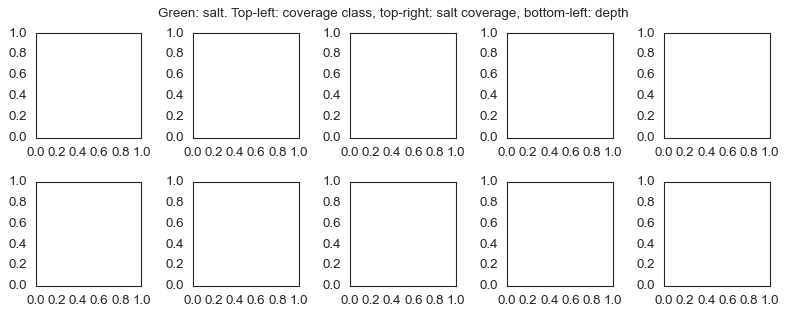

In [32]:
import matplotlib.pyplot as plt

# Show some example images
max_images = 10
grid_width = 5  # Set grid width based on number of images you want to show
grid_height = int(max_images / grid_width)
grid_height = max(1, int(max_images / grid_width))

# Create a grid of subplots
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))

# Loop through each index and display images
for i, idx in enumerate(train_df.index[:max_images]):
    img_array = train_df.loc[idx].images  # Array of images for this index
    mask = train_df.loc[idx].masks

    # Ensure that there are multiple images for the index (you could decide how to handle this)
    for j, img in enumerate(img_array):
        # Check if img is a 2D or 3D array
        if img.ndim == 2:  # Grayscale image
            ax = axs[int(i / grid_width), i % grid_width]
            ax.imshow(img, cmap="Greys")
            ax.imshow(mask, alpha=0.3, cmap="Greens")
        elif img.ndim == 3:  # RGB image
            ax = axs[int(i / grid_width), i % grid_width]
            ax.imshow(img)  # RGB image doesn't need a colormap
            ax.imshow(mask, alpha=0.3, cmap="Greens")

        # Adding text annotations
        ax.text(1, img_size_ori - 1, train_df.loc[idx].z, color="black")
        ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
        ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")

        # Hide tick labels
        ax.set_yticklabels([])
        ax.set_xticklabels([])

# Set the title for the whole figure
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Adjust layout to prevent overlap of subplots and titles
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the title space
plt.show()


In [7]:
from PIL import Image
import numpy as np
from PIL import Image
# Define the upsample function to resize images
def upsample(image, target_size=(256, 256)):
    image = Image.fromarray(image)  # Convert numpy array to PIL Image
    image = image.resize(target_size, Image.Resampling.LANCZOS)  # Use LANCZOS for high-quality resizing
    return np.array(image)


# Example target image size
img_size_target = (256, 256)

# Now, you can use this upsample function
train_df = pd.DataFrame({
    'images': [np.random.rand(100, 100)] * 100,  # Example image data
    'masks': [np.random.rand(100, 100)] * 100,   # Example mask data
    'coverage': np.random.rand(100),             # Example coverage values
    'z': np.random.rand(100),                    # Example z values
    'coverage_class': np.random.choice([0, 1], 100)  # Example coverage class
})

# Now, use train_test_split with the upsample function
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array([upsample(img) for img in train_df['images']]).reshape(-1, img_size_target[0], img_size_target[1], 1),
    np.array([upsample(mask) for mask in train_df['masks']]).reshape(-1, img_size_target[0], img_size_target[1], 1),
    train_df['coverage'].values,
    train_df['z'].values,
    test_size=0.2,
    stratify=train_df['coverage_class'],
    random_state=1337
)



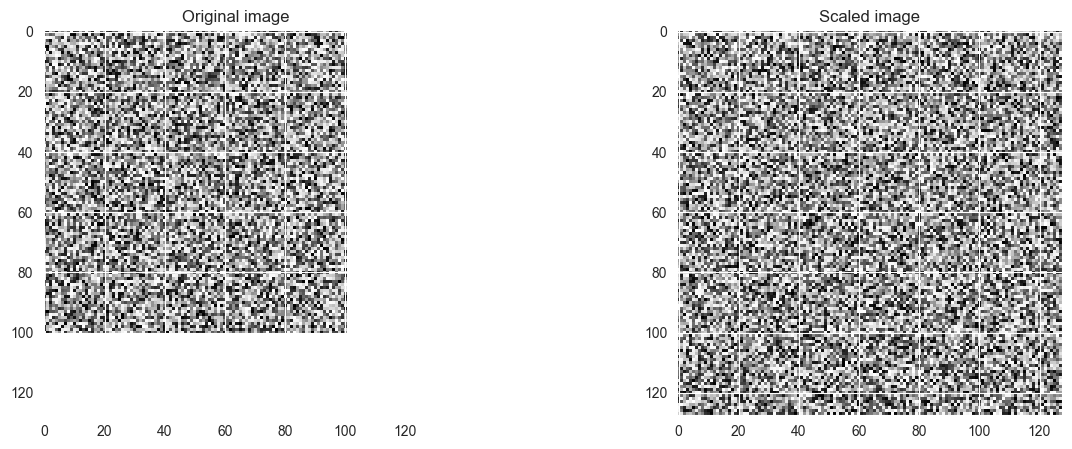

In [6]:
# Example setup for debugging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dummy data setup
img_size_ori = 101
img_size_target = 128
train_df = pd.DataFrame({'images': [np.random.rand(101, 101) for _ in range(20)]})
ids_train = list(range(len(train_df)))
x_train = np.random.rand(20, 128, 128, 1)  # Example scaled images

# Your code snippet
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")
plt.show()


In [8]:
# Building the model
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

def conv_block_simple_no_bn(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

In [10]:
from keras import backend as K

K.clear_session()

K.clear_session()
def get_unet_resnet(input_shape):
    resnet_base = ResNet50(input_shape=input_shape, include_top=False)

    for l in resnet_base.layers:
        l.trainable = True
    conv1 = resnet_base.get_layer("activation_1").output
    conv2 = resnet_base.get_layer("activation_10").output
    conv3 = resnet_base.get_layer("activation_22").output
    conv4 = resnet_base.get_layer("activation_40").output
    conv5 = resnet_base.get_layer("activation_49").output

    up6 = concatenate([UpSampling2D()(conv5), conv4], axis=-1)
    conv6 = conv_block_simple(up6, 256, "conv6_1")
    conv6 = conv_block_simple(conv6, 256, "conv6_2")

    up7 = concatenate([UpSampling2D()(conv6), conv3], axis=-1)
    conv7 = conv_block_simple(up7, 192, "conv7_1")
    conv7 = conv_block_simple(conv7, 192, "conv7_2")

    up8 = concatenate([UpSampling2D()(conv7), conv2], axis=-1)
    conv8 = conv_block_simple(up8, 128, "conv8_1")
    conv8 = conv_block_simple(conv8, 128, "conv8_2")

    up9 = concatenate([UpSampling2D()(conv8), conv1], axis=-1)
    conv9 = conv_block_simple(up9, 64, "conv9_1")
    conv9 = conv_block_simple(conv9, 64, "conv9_2")

    up10 = UpSampling2D()(conv9)
    conv10 = conv_block_simple(up10, 32, "conv10_1")
    conv10 = conv_block_simple(conv10, 32, "conv10_2")
    conv10 = SpatialDropout2D(0.2)(conv10)
    x = Conv2D(1, (1, 1), activation="sigmoid", name="prediction")(conv10)
    model = Model(resnet_base.input, x)
    return model

In [2]:
import warnings
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_file  # Correct import

# Define the ResNet50 weight URLs
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'keras.., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'keras.., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


In [1]:
def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

#     x = AveragePooling2D((7, 7), name='avg_pool')(x)

#     if include_top:
#         x = Flatten()(x)
#         x = Dense(classes, activation='softmax', name='fc1000')(x)
#     else:
#         if pooling == 'avg':
#             x = GlobalAveragePooling2D()(x)
#         elif pooling == 'max':
#             x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models',
                                    md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path,by_name=True)
    return model

In [17]:
def relu6(x):
    return K.relu(x, max_value=6)

In [5]:
# model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True)
# model = get_unet_mobilenet(input_shape=(128,128,1))
# model = get_unet_resnet(input_shape=(img_size_target,img_size_target,3))
img_size_target = 128  # Replace with the target size
input_shape = (img_size_target, img_size_target, 3)  # Or (img_size_target, img_size_target, 1) for grayscale

In [7]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [11]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) +
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [12]:
import gc
gc.enable()

In [13]:
from tensorflow.keras.applications import ResNet50

# Create the ResNet50 base model without the top layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


In [14]:
# Ensure the ResNet base model is properly initialized
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Print layer names to identify the correct layers
for layer in resnet_base.layers:
    print(layer.name)

# Update `get_unet_resnet` function with correct layer names
def get_unet_resnet(input_shape=(128, 128, 3)):
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # For example:
    x = base_model.output
    x = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    return model


# Call your function and compile the model
model = get_unet_resnet(input_shape=(128, 128, 3))
model.compile(loss=bce_dice_loss, optimizer="adam", metrics=[my_iou_metric])


input_layer_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn


In [17]:
import numpy as np

# Example initialization of x_train
# Replace with actual data loading
x_train = np.random.rand(100, 128, 128, 3)  # Dummy data (100 samples of 128x128 RGB images)
y_train = np.random.rand(100, 128, 128, 1)  # Dummy labels (grayscale masks)

# Augmenting the dataset
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)


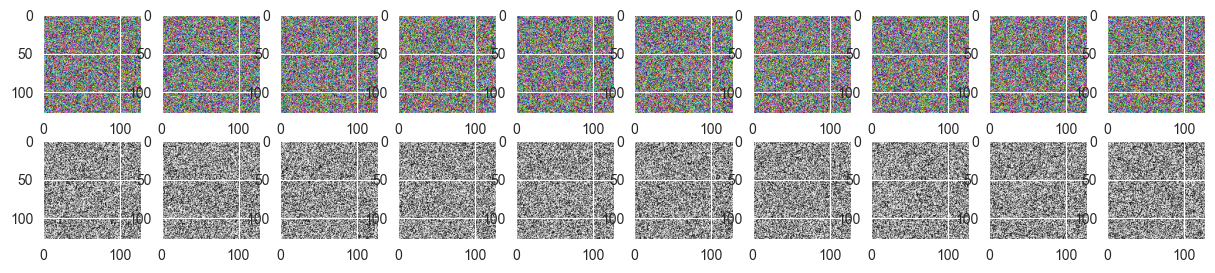

Text(0.5, 0.98, 'Top row: original images, bottom row: augmented images')

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[i].squeeze(), cmap="Greys")
plt.show()

for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

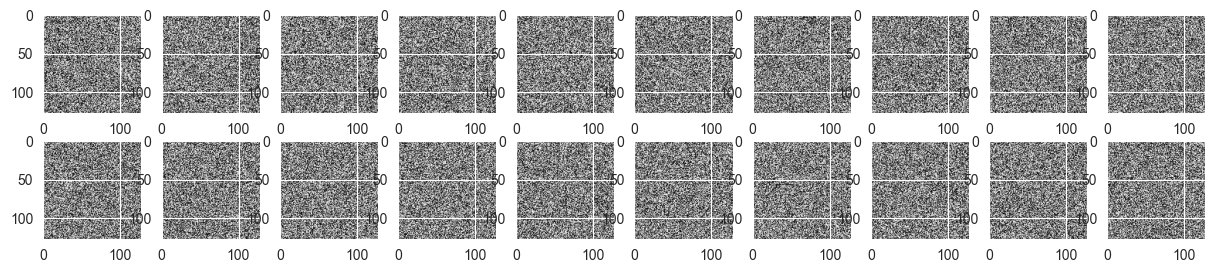

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize x_train and x_valid with dummy data (replace with your actual data)
x_train = np.random.rand(100, 128, 128, 1)  # 100 grayscale images of size 128x128
x_valid = np.random.rand(20, 128, 128, 1)   # 20 grayscale images of size 128x128

# Convert grayscale to 3-channel format (e.g., for RGB compatibility)
x_train = np.repeat(x_train, 3, axis=3)
x_valid = np.repeat(x_valid, 3, axis=3)

# Visualize some samples from x_train
fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[1][i].imshow(x_valid[i].squeeze(), cmap="Greys")
plt.show()


Training the model

x_train shape: (100, 128, 128, 3)
y_train shape: (100,)
x_valid shape: (20, 128, 128, 3)
y_valid shape: (20,)


C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,722 (49.36 MB)

 Trainable params: 12,939,722 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

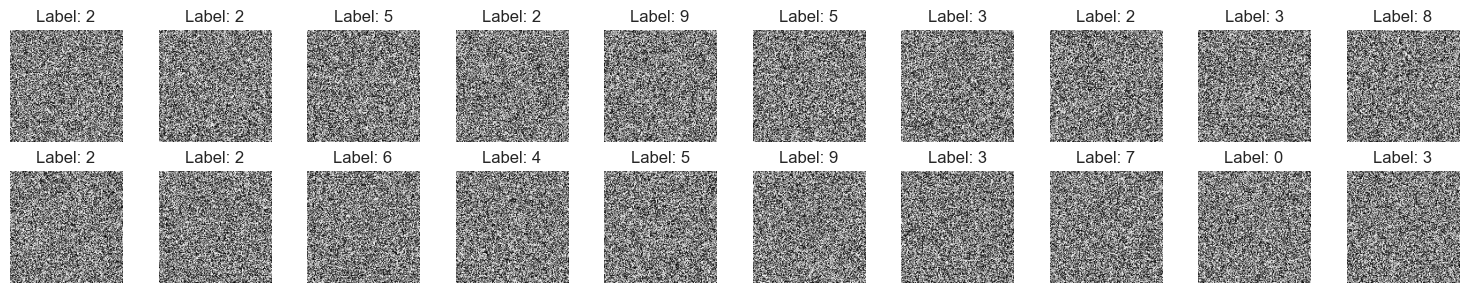

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Initialize x_train, x_valid, y_train, and y_valid with dummy data (replace with your actual data)
x_train = np.random.rand(100, 128, 128, 1)  # 100 grayscale images of size 128x128
x_valid = np.random.rand(20, 128, 128, 1)   # 20 grayscale images of size 128x128
y_train = np.random.randint(0, 10, size=(100,))  # 100 random labels for 10 classes
y_valid = np.random.randint(0, 10, size=(20,))   # 20 random labels for 10 classes

# Convert grayscale to 3-channel format (e.g., for RGB compatibility)
x_train = np.repeat(x_train, 3, axis=3)
x_valid = np.repeat(x_valid, 3, axis=3)

# Flatten y_train and y_valid to ensure they are 1D arrays
y_train = np.array(y_train).reshape(-1)
y_valid = np.array(y_valid).reshape(-1)

# Print shapes to verify
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape)
print("y_valid shape:", y_valid.shape)

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # 10 classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Visualize some samples from x_train and x_valid
fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].set_title(f"Label: {y_train[i]}")
    axs[0][i].axis('off')

    axs[1][i].imshow(x_valid[i].squeeze(), cmap="Greys")
    axs[1][i].set_title(f"Label: {y_valid[i]}")
    axs[1][i].axis('off')

plt.tight_layout()
plt.show()


In [27]:
import gc

# Safely delete variables if they exist
for var_name in ['ids_train', 'x_train', 'y_train', 'cov_train', 'depth_train', 'depths_df', 'depth_test']:
    if var_name in locals() or var_name in globals():
        del globals()[var_name]

# Trigger garbage collection
gc.collect()

print("Cleanup complete.")


Cleanup complete.


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,745 (2.96 MB)

 Trainable params: 775,745 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 13s/step - accuracy: 0.5001 - loss: 0.6941 - val_accuracy: 0.5007 - val_loss: 0.6933
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 11s/step - accuracy: 0.5001 - loss: 0.6933 - val_accuracy: 0.4994 - val_loss: 0.6932
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 50s 11s/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5007 - val_loss: 0.6931
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 11s/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.4995 - val_loss: 0.6932
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 11s/step - accuracy: 0.5001 - loss: 0.6931 - val_accuracy: 0.4998 - val_loss: 0.6931
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 11s/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5007 - val_loss: 0.6931
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 11s/step - accuracy: 0.5001 - loss: 0.6931 - val_accuracy: 0.4994 - val_loss: 0.6931
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 12s/step - accuracy: 0.5001 - loss: 0.6931 - val_accuracy: 0.4995 - val_loss: 0.6931


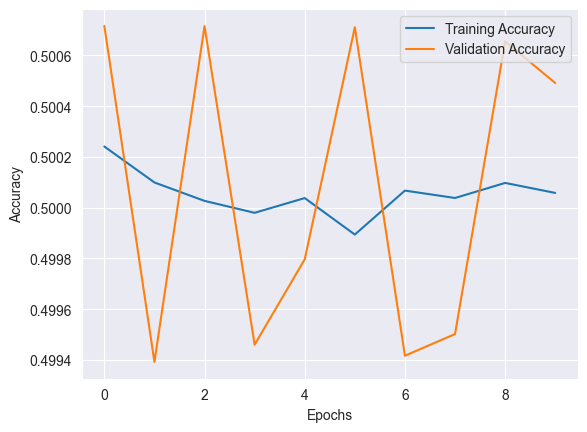

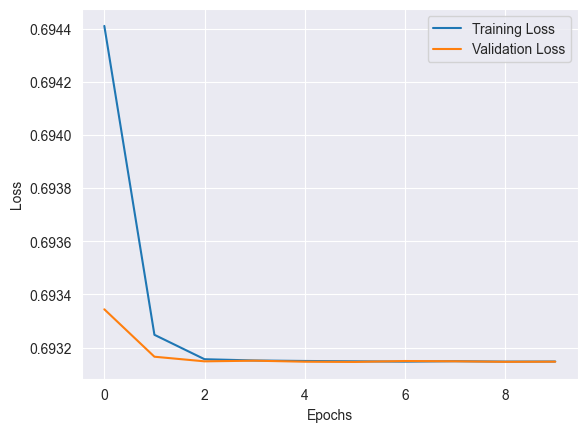

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt

# Define the model architecture
input_layer = Input(shape=(256, 256, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Bottleneck
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Output Layer: match the target shape (256x256x1)
output_layer = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

# Build the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model (assuming you have x_train, y_train, x_valid, y_valid datasets)
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10, batch_size=32)

# Plot the training and validation accuracy (or IOU metrics if available)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Optionally, plot the loss or other metrics like IOU
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [ ]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict([x_test]).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict([x_test_reflect]).reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [1]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict([x_test]).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict([x_test_reflect]).reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [25]:
import os
from PIL import Image

# Specify the directory where your images are stored
image_folder = 'models/'

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]

# Check if the image_files list is empty
if not image_files:
    print("No image files found in the specified directory.")
else:
    print(f"Found {len(image_files)} images: {image_files}")

    # Set grid dimensions: Ensure grid_height and grid_width are calculated correctly
    grid_width = 5  # Number of columns in the grid
    grid_height = (len(image_files) + grid_width - 1) // grid_width  # Calculate number of rows based on the number of images

    # Create a new blank image for the collage
    image_width, image_height = Image.open(os.path.join(image_folder, image_files[0])).size
    collage_width = grid_width * image_width
    collage_height = grid_height * image_height
    collage = Image.new('RGB', (collage_width, collage_height))

    # Paste each image into the collage
    for i, image_file in enumerate(image_files):
        img = Image.open(os.path.join(image_folder, image_file))
        x = (i % grid_width) * image_width
        y = (i // grid_width) * image_height
        collage.paste(img, (x, y))

    # Save the resulting collage
    collage.save('collage_output.jpg')


No image files found in the specified directory.


# Scoring
Score the model and do a threshold optimization by the best IoU.

In [17]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in

    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)